In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-18:] == 'VESUVIUS_Challenge':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/VESUVIUS_Challenge/jupyter notebooks
Current path:/Users/gregory/PROJECT_ML/VESUVIUS_Challenge


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import PIL.Image as Image
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from ipywidgets import interact, fixed
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
PREFIX = 'kaggle/input/vesuvius-challenge/train/3/'
BUFFER = 30  # Buffer size in x and y direction
Z_START = 27 # First slice in the z direction to use
Z_DIM = 10

In [4]:
z_slices_fnames = []

In [5]:
z_slices_fnames += sorted(glob.glob(f"{'kaggle/input/vesuvius-challenge/'}/{'train'}/{1}/surface_volume/*.tif"))[Z_START:Z_START + Z_DIM]

In [6]:
z_slices_fnames += sorted(glob.glob(f"{'kaggle/input/vesuvius-challenge/'}/{'train'}/{2}/surface_volume/*.tif"))[Z_START:Z_START + Z_DIM]

In [7]:
z_slices_fnames

['kaggle/input/vesuvius-challenge//train/1/surface_volume/27.tif',
 'kaggle/input/vesuvius-challenge//train/1/surface_volume/28.tif',
 'kaggle/input/vesuvius-challenge//train/1/surface_volume/29.tif',
 'kaggle/input/vesuvius-challenge//train/1/surface_volume/30.tif',
 'kaggle/input/vesuvius-challenge//train/1/surface_volume/31.tif',
 'kaggle/input/vesuvius-challenge//train/1/surface_volume/32.tif',
 'kaggle/input/vesuvius-challenge//train/1/surface_volume/33.tif',
 'kaggle/input/vesuvius-challenge//train/1/surface_volume/34.tif',
 'kaggle/input/vesuvius-challenge//train/1/surface_volume/35.tif',
 'kaggle/input/vesuvius-challenge//train/1/surface_volume/36.tif',
 'kaggle/input/vesuvius-challenge//train/2/surface_volume/27.tif',
 'kaggle/input/vesuvius-challenge//train/2/surface_volume/28.tif',
 'kaggle/input/vesuvius-challenge//train/2/surface_volume/29.tif',
 'kaggle/input/vesuvius-challenge//train/2/surface_volume/30.tif',
 'kaggle/input/vesuvius-challenge//train/2/surface_volume/31.t

In [8]:
images = [np.array(Image.open(filename), dtype=np.float32)/65535.0 for filename in tqdm(sorted(glob.glob(PREFIX+"surface_volume/*.tif"))[Z_START:Z_START+Z_DIM])]
image_stack = torch.stack([torch.from_numpy(image) for image in images], dim=0).to(DEVICE)
#Z_START =  # First slice in the z direction to use
#Z_DIM = image_stack.shape[0]   # Number of slices in the z direction

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.54it/s]


In [9]:
image_stack.shape

Z_DIM = image_stack.shape[0]   # Number of slices in the z direction

In [10]:
image_stack.shape

torch.Size([10, 7606, 5249])

In [11]:
class SubvolumeDataset(data.Dataset):
    
    def __init__(self, image_stack, label, pixels):
        self.image_stack = image_stack
        self.label = label
        self.pixels = pixels
        
    def __len__(self):
        return len(self.pixels)
    
    def __getitem__(self, index):
        y, x = self.pixels[index]

        subvolume = self.image_stack[:, y-BUFFER:y+BUFFER+1, x-BUFFER:x+BUFFER+1].view(1, Z_DIM, BUFFER*2+1, BUFFER*2+1)
        inklabel = self.label[y, x].view(1)
        return subvolume, inklabel


In [12]:
mask = np.array(Image.open(PREFIX+"mask.png").convert('1'))
label = torch.from_numpy(np.array(Image.open(PREFIX+"inklabels.png"))).gt(0).float().to(DEVICE)

In [13]:
a = torch.ones((10,20,30))
b = torch.zeros((10,20,30))
aa = torch.stack([a,a], dim=0)
bb = torch.stack([b,b], dim=0)
aaa = [aa,bb]

In [14]:
aa.shape

torch.Size([2, 10, 20, 30])

In [15]:
volume = torch.cat([aaa[0], aaa[1]], axis=1)

In [16]:
volume.shape

torch.Size([2, 20, 20, 30])

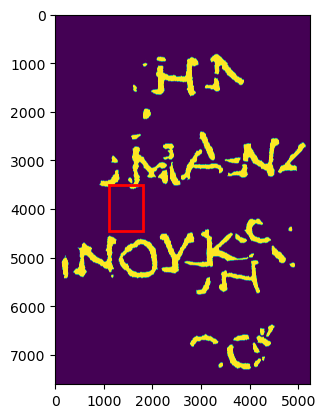

In [17]:
rect = (1100, 3500, 700, 950)
fig, ax = plt.subplots()
ax.imshow(label.cpu())
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)
plt.show()

In [18]:
# part for validation to be removed
rect = (1100, 3500, 700, 950)

#Create vector of zeros (size of mask)
not_border = np.zeros(mask.shape, dtype=bool)

# set the borders the size of BUFFER to be 0's (False) and the rest 1's (True)
not_border[BUFFER:mask.shape[0]-BUFFER, BUFFER:mask.shape[1]-BUFFER] = True

# we make sure the borders of size buffer are 0's or False 
arr_mask = np.array(mask) * not_border

# create tensor of zeros and set the removed/validatoion part to True
inside_rect = np.zeros(mask.shape, dtype=bool) * arr_mask
inside_rect[rect[1]:rect[1]+rect[3]+1, rect[0]:rect[0]+rect[2]+1] = True

# create a tensor similar to arr_mask and set the removed part to False
outside_rect = np.ones(mask.shape, dtype=bool) * arr_mask
outside_rect[rect[1]:rect[1]+rect[3]+1, rect[0]:rect[0]+rect[2]+1] = False

# we obtain indices for validation rectangle
pixels_inside_rect = np.argwhere(inside_rect)

# we obtain indices without the validation rectangle part
pixels_outside_rect = np.argwhere(outside_rect)


In [19]:
l=[[] for _ in range(3)]
l

[[], [], []]

In [20]:
train_dataset = SubvolumeDataset(image_stack, label, pixels_outside_rect)

In [21]:
k=0
a,b = None, None
for s,i in train_dataset:
    if k==2:
        break
    a =s
    b =i
    k+=1
    

In [22]:
# part with ink
train_dataset.label[5001, 2583]
train_dataset.pixels[18100000]
print(train_dataset[18100000][0].shape,train_dataset[18100000][1])

torch.Size([1, 10, 61, 61]) tensor([0.])


In [23]:
def load_slices( z_slices_fnames):
    images = []
    for z, filename in tqdm(enumerate(z_slices_fnames)):
        img = Image.open(filename)
        img = resize(img)
        z_slice = np.array(img, dtype="float32")/65535.0
        images.append(z_slice)
    return torch.stack([torch.from_numpy(image) for image in images], dim=0).to(DEVICE)



def load_mask( split, index):
    img = Image.open(f"{PATH}/{split}/{index}/mask.png").convert('1')
    img = resize(img)
    return np.array(img)



def load_labels( split, index):
    img = Image.open(f"{PATH}/{split}/{index}/inklabels.png")
    img = resize(img)
    return torch.from_numpy(np.array(img)).gt(0).float().to(DEVICE)


def resize( img):
    current_width, current_height = img.size
    aspect_ratio = current_width / current_height
    new_width = int(5000 * aspect_ratio)
    new_size = (new_width, 5000)
    img = img.resize(new_size)
    return img



def split_train_val(mask):
    rect = self.validation_rect
    not_border = np.zeros(mask.shape, dtype=bool)
    not_border[self.buffer:mask.shape[0] - 30, 30:mask.shape[1] - 30] = True
    arr_mask = np.array(mask) * not_border
    inside_rect = np.zeros(mask.shape, dtype=bool) * arr_mask
    inside_rect[rect[1]:rect[1] + rect[3] + 1, rect[0]:rect[0] + rect[2] + 1] = True
    outside_rect = np.ones(mask.shape, dtype=bool) * arr_mask
    outside_rect[rect[1]:rect[1] + rect[3] + 1, rect[0]:rect[0] + rect[2] + 1] = False
    pixels_inside_rect = np.argwhere(inside_rect)
    pixels_outside_rect = np.argwhere(outside_rect)
    return pixels_outside_rect, pixels_inside_rect




In [24]:
PATH = 'kaggle/input/vesuvius-challenge/'
rect = (1100, 3500, 700, 950)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_start = 27
z_dim = 10
scroll_fragments = [1,2,3]

In [25]:
z_slices = [[] for _ in range(3)]
labels =  [[] for _ in range(3)]
masks = [[] for _ in range(3)]

In [26]:
for i in scroll_fragments:
    # get z_slices .tiffs paths
    z_slices[i-1] += sorted(glob.glob(f"{PATH}/{'train'}/{i}/surface_volume/*.tif"))[z_start:z_start + z_dim]
    # get labels
    labels[i-1] = load_labels('train', i)
    # get masks
    masks[i-1] = load_mask('train', i)

/Users/gregory/anaconda3/lib/python3.10/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [27]:
 # get images of z-slices and convert them to tensors
images = [[] for _ in range(len(scroll_fragments))]
for i in range(len(scroll_fragments)):
    images[i] = load_slices(z_slices[i])

10it [00:02,  3.76it/s]
10it [00:06,  1.65it/s]
10it [00:02,  4.94it/s]


In [28]:
images[0].shape

torch.Size([10, 5000, 3868])

In [29]:
images[1].shape

torch.Size([10, 5000, 3204])

In [30]:
images[2].shape

torch.Size([10, 5000, 3450])

In [31]:
images_tensors = torch.cat([image for image in images], axis=-1)
label_tensors =  torch.cat([label for label in labels], axis=-1)
mask_tensors =  np.concatenate([mask for mask in masks], axis=-1)

In [32]:
label_tensors.shape

torch.Size([5000, 10522])

In [33]:
images_tensors.shape

torch.Size([10, 5000, 10522])

In [34]:
mask_tensors.shape

(5000, 10522)

In [37]:
label_tensors.shape

torch.Size([5000, 10522])

In [ ]:
data

In [35]:
from torchvision import models
models.resnet18(pretrained=False)

/Users/gregory/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gregory/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  